# Part 1: Imports + Setup

Import necessary packages:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import time

Define label hot encoding:

In [3]:
LABEL_ENCODING = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprised',
    6: 'natural',
}

# Part 2: Defining the Network

In [4]:
class EmojifyNet(nn.Module):
    def __init__(self):
        super(EmojifyNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)

        self.mxpl1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, stride=1, padding=1)

        self.mxpl2 = nn.MaxPool2d(3, 3)

        self.fc1 = nn.Linear(18432, 1024)
        self.fc2 = nn.Linear(1024, 7)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = self.mxpl1(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = self.conv4(x)
        x = F.relu(x)

        x = self.conv5(x)
        x = F.relu(x)

        x = self.mxpl2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    def load_model(self, file_path):
        self.load_state_dict(torch.load(file_path, map_location=torch.device('cpu')))

In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    return test_loss, test_accuracy

# Part 3: Loading Data + Augmentation

Training Examples: 28709
Testing Examples: 7178

Looking at example 12345 with label 'happy':
torch.Size([1, 40, 40])


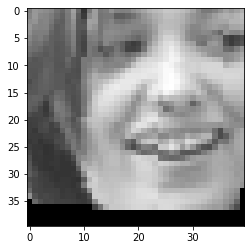

In [6]:
MAX_RESIZE = 0.2

transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(int(48 * (2 * MAX_RESIZE * np.random.random() + (1 - MAX_RESIZE)) + 0.5)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(40, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(0, 1),
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomCrop(40, padding=4),
    transforms.ToTensor(),
])

data_train = datasets.ImageFolder(root="../data/train", transform=transform_train)
data_test = datasets.ImageFolder(root="../data/test", transform=transform_test)

print(f"Training Examples: {len(data_train)}")
print(f"Testing Examples: {len(data_test)}")

indx = 12345
example = data_train[indx][0]
label   = data_train[indx][1]

print(f"\nLooking at example {indx} with label '{LABEL_ENCODING[label]}':")
print(example.shape)
plt.imshow(np.squeeze(example), cmap='gray')

# Part 4: Training the Network

In [7]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 512
TEST_BATCH_SIZE = 10
EPOCHS = 100
LEARNING_RATE = 0.08
MOMENTUM = 0.9
USE_CUDA = True
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.001

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=True)

model = EmojifyNet().to(device)
model.load_model('best-model')
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = 0

train_losses, test_losses, test_accuracies = [], [], []
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

for epoch in range(start_epoch, EPOCHS + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
    test_loss, test_accuracy = test(model, device, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Using device cpu


KeyboardInterrupt: 

Final train loss: 0.8953868140254104
Final test loss:  1.2624089059207924


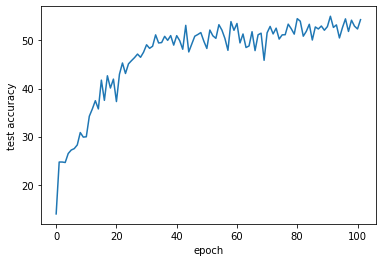

In [172]:
print(f"Final train loss: {train_losses[-1]}")
print(f"Final test loss:  {test_losses[-1]}")

x_axis = np.arange(0, EPOCHS + 2)
plt.plot(x_axis, test_accuracies)
plt.xlabel('epoch')
plt.ylabel('test accuracy')
model.save_model('best-model')

# Test Model

In [8]:
import cv2

model.load_model('best-model')
cascPath = 'haarcascade_frontalface_default.xml'
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascPath)
video_capture = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        gray_frame = gray[y:y+h, x:x+w]

        loader = transforms.Compose([transforms.ToPILImage(), transforms.Resize(40), transforms.ToTensor()])
        cropped_img = loader(gray_frame)
        output = model(cropped_img[None, ...])
        
        pred = output.max(1)[1].item()
        cv2.putText(frame, LABEL_ENCODING[pred], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0))

        emoji = cv2.imread(f"../emojis/{LABEL_ENCODING[pred]}.png")
        emoji = cv2.resize(emoji, (w, h))
        true_face = frame[y:y+emoji.shape[1], x:x+emoji.shape[0]]
        cv2.imshow("true_face", true_face)
        frame[y:y+emoji.shape[1], x:x+emoji.shape[0]] = emoji



    # Display the resulting frame
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 